In [ ]:
# https://github.com/facebookresearch/segment-anything#installation
# https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/how-to-segment-anything-with-sam.ipynb#scrollTo=pi3C4uDWo10h

In [ ]:
!jt -t chesterish

# Installing SAM

In [ ]:
#!pip install git+https://github.com/facebookresearch/segment-anything.git

In [ ]:
#!pip install opencv-python pycocotools matplotlib onnxruntime onnx

In [ ]:
#### from numpy import *
from collections import Counter
import matplotlib
from matplotlib.pyplot import *
%matplotlib inline
# import matplotlib.ticker as plticker
# from mpl_toolkits.axes_grid1 import make_axes_locatable
import re
import string
from collections import Counter
# import networkx as nx
from pandas import *
import scipy
# Magic function to make matplotlib inline; other style specs must come AFTER
# %matplotlib inline
# %matplotlib notebook
# This enables SVG graphics inline.  There is a bug, so uncomment if it works.
# %config InlineBackend.figure_formats = {'svg',}
# This enables high resolution PNGs. SVG is preferred, but has problems
# rendering vertical and horizontal lines
import seaborn as sns
%config InlineBackend.figure_formats = {'png', 'retina'}
# rc = {'lines.linewidth': 2, 
#       'axes.labelsize': 24, 
#       'axes.titlesize': 24,
# #       'axes.xtick.labelsize': 20,
# #       'axes.ytick.labelsize': 20,
#       'axes.facecolor': 'None'}
# #       'axes.facecolor': 'DFDFE5'}
# sns.set_context('notebook', rc=rc)
# sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5,'axes.labelsize': 24})
# # sns.set(style='white', rc = rc)
# sns.set_style('ticks', rc = rc)
# # sns.set_style('white', rc=rc)
# # sns.set_style('darkgrid', rc=rc)
# # sns.set_style('darkgrid', rc=rc)
rc = {'lines.linewidth': 1, 
      'axes.labelsize': 20, 
      'axes.titlesize': 20,
      'axes.xtick.labelsize': 16,
      'axes.ytick.labelsize': 16,
      'axes.facecolor': 'None'}
#       'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc = rc)
sns.set_context("paper", font_scale = 1.5)
# sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5,'axes.labelsize': 24})
# sns.set(style='white', rc = rc)
sns.set_style('ticks', rc = rc)


"In SAM2, a "prompt" is a user-provided input that guides the model to segment specific objects or regions within an image or video. These prompts can be in the form of points, bounding boxes, or masks, and they help the model focus on the areas of interest. "

# Loading torch

In [1]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

In [2]:
torch.set_default_dtype(torch.float32)

In [3]:
# DEVICE = torch.device("mps")
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

MODEL_TYPE = "vit_h"

In [4]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /Users/vitaly


In [ ]:
# !mkdir -p {HOME}/weights
# !wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -P {HOME}/weights

In [5]:
import os

CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

/Users/vitaly/weights/sam_vit_h_4b8939.pth ; exist: True


In [ ]:
# !mkdir -p {HOME}/sam2_data

In [6]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam = sam_model_registry[MODEL_TYPE](checkpoint = CHECKPOINT_PATH).to(torch.float32).to(device = DEVICE)




# Automated Mask Generation

In [7]:
mask_generator = SamAutomaticMaskGenerator(sam)

In [8]:
import os


IMAGE_NAME = "2024-05-21_14-25-48_Üben.MOV_159.jpg"


IMAGE_PATH = os.path.join(HOME, "sam2_data", IMAGE_NAME)

In [ ]:
# !pip install supervision

# Generate masks with SAM

In [9]:
# https://github.com/ChaoningZhang/MobileSAM/pull/124/commits/f590aeb24b69937aad6963fbf375bc35fbc9376a
import cv2
import supervision as sv

image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

sam_result = mask_generator.generate(image_rgb)

SamAutomaticMaskGenerator returns a list of masks, where each mask is a dict containing various information about the mask:

segmentation - [np.ndarray] - the mask with (W, H) shape, and bool type
area - [int] - the area of the mask in pixels
bbox - [List[int]] - the boundary box of the mask in xywh format
predicted_iou - [float] - the model's own prediction for the quality of the mask
point_coords - [List[List[float]]] - the sampled input point that generated this mask
stability_score - [float] - an additional measure of mask quality
crop_box - List[int] - the crop of the image used to generate this mask in xywh format

In [10]:
print(sam_result[0].keys())

dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


# Results visualisation with Supervision

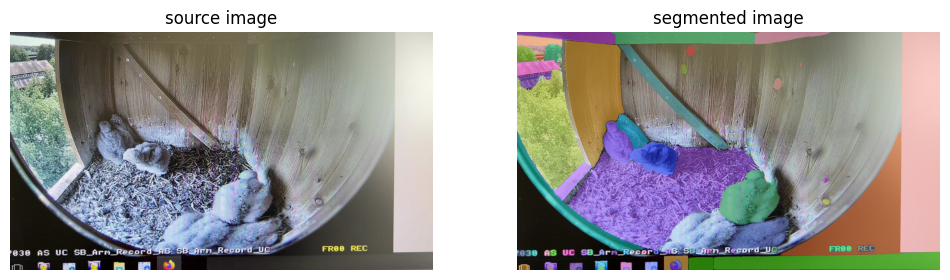

In [21]:
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections.from_sam(sam_result=sam_result)

annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[image_bgr, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

# Interaction with segmentation results

In [12]:
masks = [
    mask['segmentation']
    for mask
    in sorted(sam_result, key=lambda x: x['area'], reverse=True)
]

len(masks)

65

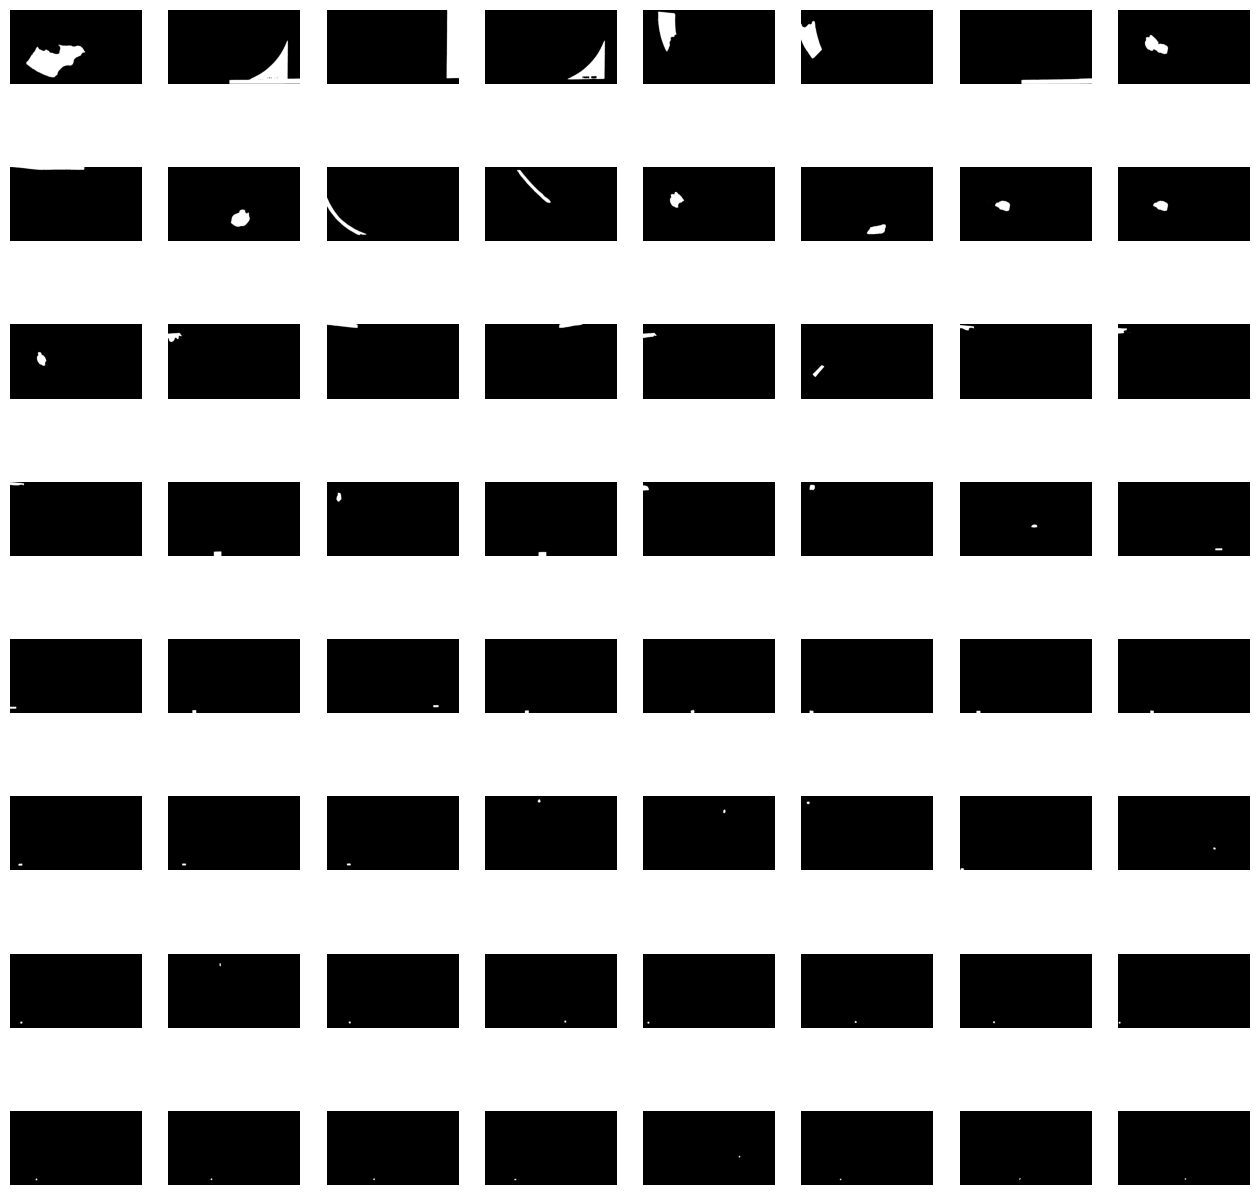

In [13]:
sv.plot_images_grid(
    images = masks[:64],
    grid_size = (8, int(len(masks[:64]) / 8)),
    size = (16, 16)
)

In [14]:
# helper function that loads an image before adding it to the widget

import base64

def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

In [ ]:
# !pip install jupyter_bbox_widget
# !pip install -U jupyterlab ipywidgets jupyterlab-widgets
# !jupyter nbextension enable --py widgetsnbextension
# !pip install -U ipympl

In [15]:
from jupyter_bbox_widget import BBoxWidget
import ipywidgets as widgets

widget = BBoxWidget()
widget.image = encode_image(IMAGE_PATH)
widget


BBoxWidget(colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#b…

In [17]:
mask_predictor = SamPredictor(sam)

In [22]:
import numpy as np

# default_box is going to be used if you will not draw any box on image above
# default_box = {'x': 385, 'y': 399, 'width': 153, 'height': 208, 'label': ''}
default_box = {'x': 443, 'y': 472, 'width': 0, 'height': 0, 'label': ''}


box = widget.bboxes[0] if widget.bboxes else default_box
box = np.array([
    box['x'],
    box['y'],
    box['x'] + box['width'],
    box['y'] + box['height']
])

In [23]:
import cv2
import numpy as np
import supervision as sv


image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

mask_predictor.set_image(image_rgb)

masks, scores, logits = mask_predictor.predict(
    box=box,
    multimask_output=True
)

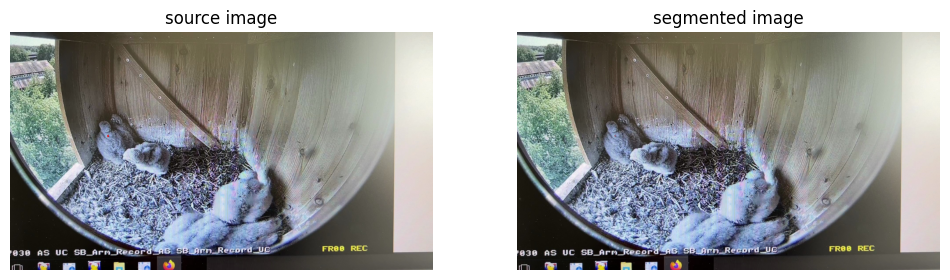

In [24]:
box_annotator = sv.BoxAnnotator(color=sv.Color.RED, color_lookup=sv.ColorLookup.INDEX)
mask_annotator = sv.MaskAnnotator(color=sv.Color.RED, color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=masks),
    mask=masks
)
detections = detections[detections.area == np.max(detections.area)]

source_image = box_annotator.annotate(scene=image_bgr.copy(), detections=detections)
segmented_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[source_image, segmented_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)